In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import bisect
import matplotlib.colors as mcolors
print(qt.__version__)
from scipy.stats import ks_2samp

5.0.4


In [3]:
def create_random_state(n):
        basis_states = [qt.basis([2]*n, [int(i) for i in format(j, f'0{n}b')]) for j in range(2**n)]
        uniform_values = np.random.uniform(0, 1, 2**n)
        coefficients = uniform_values / np.sqrt(np.sum(uniform_values**2))
    
        random_state = sum(coeff * basis for coeff, basis in zip(coefficients, basis_states))
        return random_state

def create_random_state_haar(n):
    dim = 2**n
    
    # Complex coefficients: real and imaginary parts from normal distribution
    real_parts = np.random.normal(0, 1, dim)
    imag_parts = np.random.normal(0, 1, dim)
    complex_coeffs = real_parts + 1j * imag_parts

    # Normalize the vector
    normalized_coeffs = complex_coeffs / np.linalg.norm(complex_coeffs)

    # Create basis states
    basis_states = [qt.basis([2]*n, [int(i) for i in format(j, f'0{n}b')]) for j in range(dim)]

    # Combine into a state
    random_state = sum(coeff * basis for coeff, basis in zip(normalized_coeffs, basis_states))
    
    return random_state

def compute_density_matrix(state):
        return state * state.dag()

def state_0(n):
    return qt.tensor([qt.basis(2, 0) for _ in range(n)])

def state_1(n):
    return qt.tensor([qt.basis(2, 1) for _ in range(n)])

def compute_density_matrix(state):
    return state * state.dag()

def compute_reduced_density_matrices_3(p):
    p_A = p.ptrace([0])  # Tracing out B and C
    p_B = p.ptrace([1])  # Tracing out A and C
    p_C = p.ptrace([2])  # Tracing out A and B
    p_AB = p.ptrace([0, 1])  # Tracing out C
    p_AC = p.ptrace([0, 2])  # Tracing out B
    p_BC = p.ptrace([1, 2])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_reduced_density_matrices_7(p):
    p_A = p.ptrace([0,1,2])  # Tracing out B and C
    p_B = p.ptrace([4,5,6])  # Tracing out A and C
    p_C = p.ptrace([3])  # Tracing out A and B
    p_AB = p.ptrace([0,1,2,4,5,6])  # Tracing out C
    p_AC = p.ptrace([0,1,2,3])  # Tracing out B
    p_BC = p.ptrace([3,4,5,6])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_ratio_per_bin(A, B, n):
    A = np.array(A)
    B = np.array(B)
    bins = np.linspace(0, 1, n + 1)

    counts_A, _ = np.histogram(A, bins=bins)
    counts_B, _ = np.histogram(B, bins=bins)

    # Ratio per bin, avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        M = np.where(counts_B != 0, (counts_B / counts_A) * 100, 0)

    return M

def sample_single_p_with_uniform_entropy():
    def H(p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    def invert_entropy(h, side):
        return bisect(lambda p: H(p) - h, 1e-10 if side == 'lower' else 0.5, 
                                     0.5 if side == 'lower' else 1 - 1e-10)

    h = np.random.uniform(0, 1)
    side = np.random.choice(['lower', 'upper'])
    return invert_entropy(h, side)

def shannon_entropy(probs):
    probs = np.array(probs)
    #probs = probs[probs > 0]  # Remove zero probabilities to avoid log(0)
    probs = np.clip(probs, 1e-10, 1)
    return -np.sum(probs * np.log2(probs))

def quantum_relative_entropy(rho, sigma):
    log_rho = (rho.logm())
    log_sigma = (sigma.logm())
    return (rho * (log_rho - log_sigma)).tr().real
def conditional_entropy(rho,sigma):
     return qt.entropy_vn(rho, base = 2) - qt.entropy_vn(sigma, base = 2)



def compare_histograms(A, B, bins=30):
    """
    Generates comparative histograms and computes a similarity measure.

    Parameters:
    - A, B: Arrays to compare.
    - bins: Number of histogram bins (default=30).

    Returns:
    - ks_stat: Kolmogorov-Smirnov statistic.
    - p_value: p-value indicating similarity (higher = more similar).
    """

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(A, bins=bins, alpha=0.5, label='Array A', density=True)
    plt.hist(B, bins=bins, alpha=0.5, label='Array B', density=True)
    plt.legend()
    plt.title('Comparative Histogram')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    # Perform Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(A, B)
    print(f"Kolmogorov-Smirnov Test:\nStatistic = {ks_stat:.4f}, p-value = {p_value:.4f}")

    return ks_stat, p_value


In [40]:
n = 10000
Entropies = np.zeros(n)
approxes = np.zeros(n)

num_qubits = 2
for i in range(1,n):
    random_state_1 = create_random_state(num_qubits)
    random_state_2 = create_random_state(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)
    P_1, P_2= np.random.dirichlet([0.1, 0.1])
    p_mixed = (P_1*p_random_1 + P_2*p_random_2) 

    Entropies[i] = qt.entropy_vn(p_mixed, base = 2)
    approxes[i] = 1 - ((p_mixed @ p_mixed).tr()).real


    



C:\Users\Francois\AppData\Local\Temp\ipykernel_14984\3472874937.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, y_max], [0, y_max], 'r--', color = 'gold', label='Perfect Estimation')


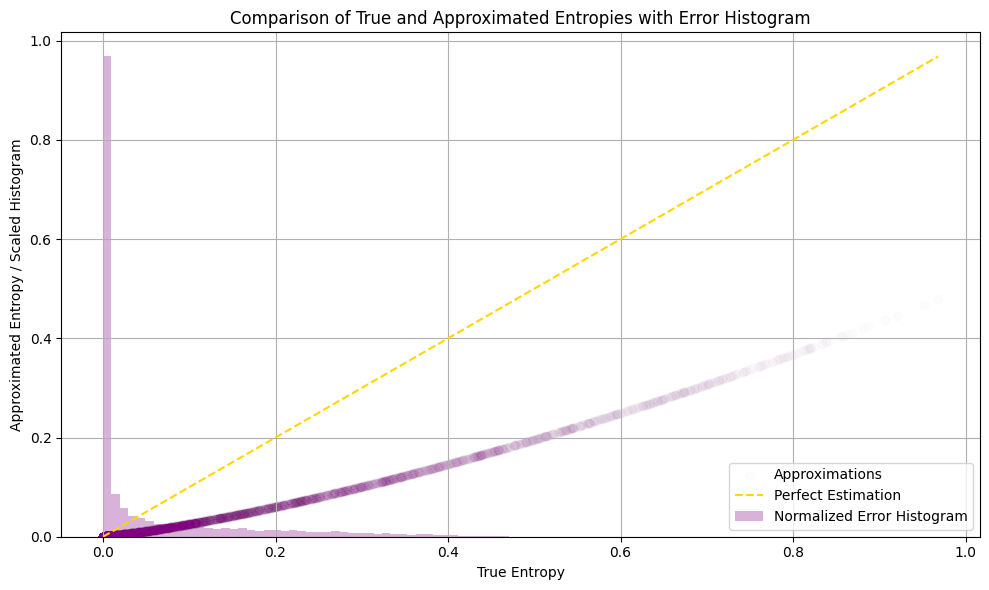

Mean of average difference: 0.05501800713190297


In [41]:
# Compute average absolute difference
average_difference = np.zeros(n)
for i in range(0,n):
    average_difference[i] = np.abs(Entropies[i] - approxes[i])

# Compute histogram data
counts, bins = np.histogram(average_difference, bins=50)
normalized_counts = counts / counts.max()  # normalize heights to [0, 1]
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Rescale histogram heights to match the y-range of your scatter plot
y_max = np.max(Entropies)
scaled_heights = normalized_counts * y_max

# Plotting
plt.figure(figsize=(10, 6))

# Scatter of entropy vs approximation
plt.scatter(Entropies, approxes, alpha=0.01, color = 'purple', label='Approximations')

# Perfect estimation line
plt.plot([0, y_max], [0, y_max], 'r--', color = 'gold', label='Perfect Estimation')

# Overlay histogram of errors, scaled to the same y-range
plt.bar(bin_centers, scaled_heights, width=np.diff(bins), alpha=0.3, label='Normalized Error Histogram', color='purple')

# Labels and legend
plt.xlabel('True Entropy')
plt.ylabel('Approximated Entropy / Scaled Histogram')
plt.title('Comparison of True and Approximated Entropies with Error Histogram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print a summary statistic
print("Mean of average difference:", np.mean(average_difference))

# We try to see what happens at different dimensions

In [8]:
n = 1000
cont = np.zeros(9)
for k in range(2,9):
    print(k)
    num_qubits = k
    Entropies = np.zeros(n)
    approxes = np.zeros(n)
    for i in range(1,n):
        random_state_1 = create_random_state(num_qubits)
        random_state_2 = create_random_state(num_qubits)

        p_random_1 = compute_density_matrix(random_state_1)
        p_random_2 = compute_density_matrix(random_state_2)
        P_1, P_2= np.random.dirichlet([0.1, 0.1])
        p_mixed = (P_1*p_random_1 + P_2*p_random_2) 

        Entropies[i] = qt.entropy_vn(p_mixed, base = 2)
        approxes[i] = 1 - ((p_mixed @ p_mixed).tr()).real
    # Compute average absolute difference
    average_difference = np.zeros(n)
    for i in range(0,n):
        average_difference[i] = np.abs(Entropies[i] - approxes[i])
    cont[k-2] = np.mean(average_difference)
    



2
3
4
5
6
7
8


C:\Users\Francois\AppData\Local\Temp\ipykernel_28476\267429890.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(cont, 'r--', color = 'gold', label='Perfect Estimation')


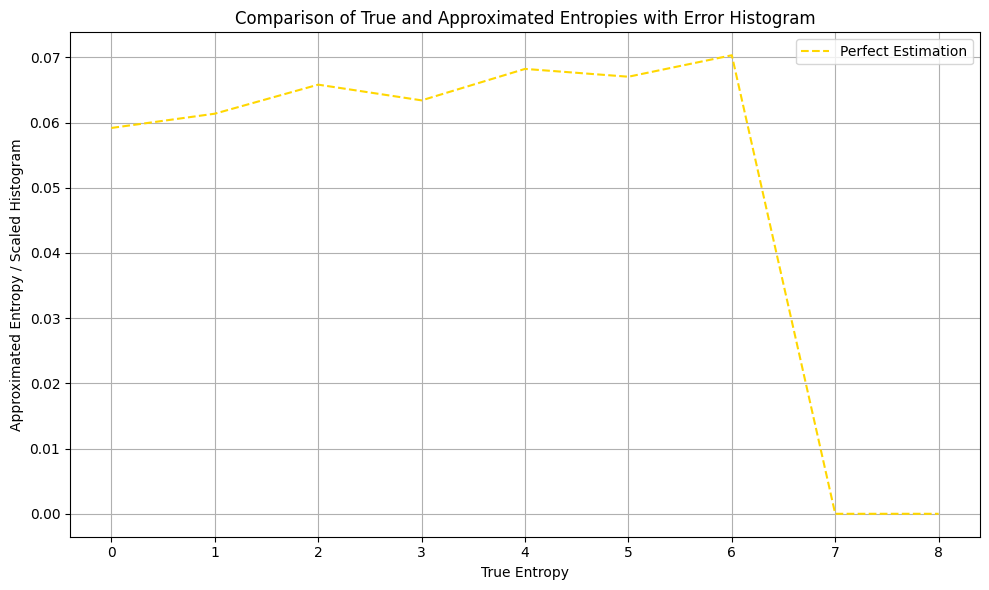

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(cont, 'r--', color = 'gold', label='Perfect Estimation')

# Labels and legend
plt.xlabel('True Entropy')
plt.ylabel('Approximated Entropy / Scaled Histogram')
plt.title('Comparison of True and Approximated Entropies with Error Histogram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()